INICIANDO A AVALIAÇÃO DO MODELO
-> Checkpoint: C:\Users\alanb\Documents\cloud-detection-dissertation\Unet_all_bands_l1c\lightning_logs\Unet_efficientnet-b1\epoch=52-train_loss=0.22-val_loss=0.24-trainHigh512.ckpt
1. Carregando modelo e datamodule...
2. Realizando inferência no conjunto de teste...


Avaliando: 100%|██████████| 975/975 [15:20<00:00,  1.06it/s]


3. Consolidando predições e preparando para análise...
4. Calculando métricas ...

        RELATÓRIO DE AVALIAÇÃO FINAL
Checkpoint: epoch=52-train_loss=0.22-val_loss=0.24-trainHigh512.ckpt

MÉTRICAS GERAIS (scikit-learn):
--------------------------------
Acurácia Geral: 0.9056
IoU (Micro):    0.8274
IoU (Macro):    0.7400
IoU (Ponderado):0.8333

F1 Score (Micro):    0.9056
F1 Score (Macro):    0.8425
F1 Score (Ponderado):0.9046
--------------------------------
--------------------------------
MÉTRICAS GERAIS (Segmentation Models PyTorch)
--------------------------------
Acurácia (Micro): 0.9528
Acurácia (Macro): 0.9528
IoU (Micro):     0.8274
IoU (Macro):     0.7400
F1 Score (Micro): 0.9056
F1 Score (Macro): 0.8425
Recall (Micro):  0.9056
Recall (Macro):  0.8346
Precision (Micro): 0.9056
Precision (Macro): 0.8510
Sensibilidade (Micro): 0.9056


                 precision    recall  f1-score   support

      Ceu Limpo     0.9399    0.9507    0.9452 136267815
  Nuvem Espessa     0.9183  

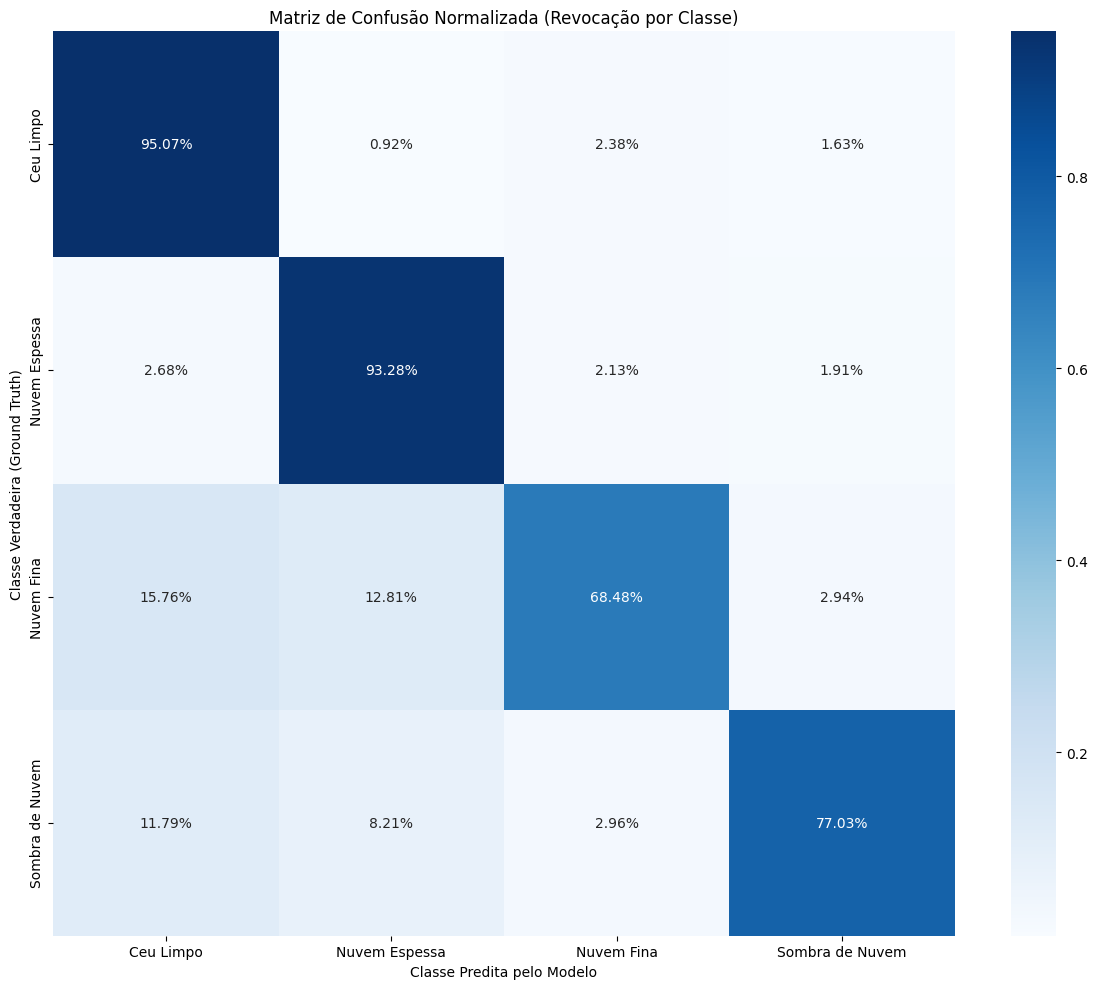

Matriz de confusão salva em: C:\Users\alanb\Documents\cloud-detection-dissertation\Unet_all_bands_l1c\lightning_logs\Unet_efficientnet-b1\output\confusion_matrix_epoch=52-train_loss=0.22-val_loss=0.24-trainHigh512.png

Análise concluída com sucesso!


In [2]:
import argparse
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.nn.functional as F
import tacoreader
import segmentation_models_pytorch as smp

# Importa as suas classes customizadas
from model import UNet_CD_Sentinel_2
from datamodule import CoreDataModule # Certifique-se que o nome do arquivo está correto

from sklearn.metrics import confusion_matrix, classification_report, jaccard_score, accuracy_score, f1_score

def plot_confusion_matrix(cm, class_names, output_path):
    """
    Renderiza e salva a matriz de confusão como uma imagem.
    A matriz é normalizada para mostrar percentuais (revocação por classe).
    """
    # Normaliza a matriz de confusão pela linha (representa a revocação de cada classe)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt=".2%",  # Formato de porcentagem com 2 casas decimais
        cmap='Blues',
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title("Matriz de Confusão Normalizada (Revocação por Classe)")
    plt.ylabel('Classe Verdadeira (Ground Truth)')
    plt.xlabel('Classe Predita pelo Modelo')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    print(f"Matriz de confusão salva em: {output_path}")

def main(checkpoint_path, df, class_names, output_dir, batch_size):
    """
    Função principal para carregar o modelo e avaliar as métricas.
    """
    print("="*50)
    print("INICIANDO A AVALIAÇÃO DO MODELO")
    print(f"-> Checkpoint: {checkpoint_path}")
    print("="*50)

    # --- 1. Carregar Modelo e Dados ---
    print("1. Carregando modelo e datamodule...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Carrega o modelo a partir do checkpoint
    model = UNet_CD_Sentinel_2.load_from_checkpoint(checkpoint_path).to(device)
    model.eval() # Coloca o modelo em modo de avaliação
    
    # Assume que o datamodule está configurado com os mesmos dados do treinamento
    # Você pode precisar ajustar os argumentos aqui se o seu datamodule precisar
    datamodule = CoreDataModule(
        dataframe=df, # O dataframe será carregado dentro do setup
        batch_size=batch_size
        )
    datamodule.setup('test') # Configura o conjunto de teste
    test_loader = datamodule.test_dataloader()
    
    # --- 2. Realizar Inferência ---
    print("2. Realizando inferência no conjunto de teste...")
    all_preds = []
    all_labels = []
    steps_outputs_metrics = []

    with torch.no_grad(): # Desativa o cálculo de gradientes para acelerar
        for batch in tqdm(test_loader, desc="Avaliando"):
            images, labels = batch
            images = images.to(device)

            logits = model(images)
            upsampled_logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode='bilinear',
                align_corners=False
            )
            preds = torch.argmax(upsampled_logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            
            tp, fp, fn, tn = smp.metrics.get_stats(
                preds, labels, mode="multiclass", num_classes=4
            )
            steps_outputs_metrics.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})

    # --- 3. Preparar Dados para Scikit-learn ---
    print("3. Consolidando predições e preparando para análise...")
    # Concatena os resultados de todos os lotes em um único tensor
    preds_tensor = torch.cat(all_preds)
    labels_tensor = torch.cat(all_labels)
    
    # Converte para NumPy e achata para um vetor 1D
    preds_np = preds_tensor.numpy().flatten()
    labels_np = labels_tensor.numpy().flatten()
    
    tp = torch.cat([x["tp"] for x in steps_outputs_metrics])
    fp = torch.cat([x["fp"] for x in steps_outputs_metrics])
    fn = torch.cat([x["fn"] for x in steps_outputs_metrics])
    tn = torch.cat([x["tn"] for x in steps_outputs_metrics])

    # --- 4. Calcular Métricas e Gerar Relatórios ---
    print("4. Calculando métricas ...")

    # Gera o relatório de classificação detalhado
    report = classification_report(
        labels_np, 
        preds_np, 
        target_names=class_names, 
        digits=4
    )

    # Calcula métricas gerais
    overall_accuracy = accuracy_score(labels_np, preds_np)
    iou_micro = jaccard_score(labels_np, preds_np, average='micro')
    iou_macro = jaccard_score(labels_np, preds_np, average='macro')
    iou_weighted = jaccard_score(labels_np, preds_np, average='weighted')
    f1_score_micro = f1_score(labels_np, preds_np, average='micro')
    f1_score_macro = f1_score(labels_np, preds_np, average='macro')
    f1_score_weighted = f1_score(labels_np, preds_np, average='weighted')
    
    acuracia_micro_smp = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
    acuracia_macro_smp = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
    iou_micro_smp = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    iou_macro_smp = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
    f1_score_micro_smp = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
    f1_score_macro_smp = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
    recall_micro_smp = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
    recall_macro_smp = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
    precision_micro_smp = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
    precision_macro_smp = smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
    sensitivity_micro_smp = smp.metrics.sensitivity(tp, fp, fn, tn, reduction="micro")

    # Monta o relatório final
    final_report = f"""
======================================================
        RELATÓRIO DE AVALIAÇÃO FINAL
======================================================
Checkpoint: {os.path.basename(checkpoint_path)}

MÉTRICAS GERAIS (scikit-learn):
--------------------------------
Acurácia Geral: {overall_accuracy:.4f}
IoU (Micro):    {iou_micro:.4f}
IoU (Macro):    {iou_macro:.4f}
IoU (Ponderado):{iou_weighted:.4f}

F1 Score (Micro):    {f1_score_micro:.4f}
F1 Score (Macro):    {f1_score_macro:.4f}
F1 Score (Ponderado):{f1_score_weighted:.4f}
--------------------------------
--------------------------------
MÉTRICAS GERAIS (Segmentation Models PyTorch)
--------------------------------
Acurácia (Micro): {acuracia_micro_smp:.4f}
Acurácia (Macro): {acuracia_macro_smp:.4f}
IoU (Micro):     {iou_micro_smp:.4f}
IoU (Macro):     {iou_macro_smp:.4f}
F1 Score (Micro): {f1_score_micro_smp:.4f}
F1 Score (Macro): {f1_score_macro_smp:.4f}
Recall (Micro):  {recall_micro_smp:.4f}
Recall (Macro):  {recall_macro_smp:.4f}
Precision (Micro): {precision_micro_smp:.4f}
Precision (Macro): {precision_macro_smp:.4f}
Sensibilidade (Micro): {sensitivity_micro_smp:.4f}


{report}
"""
    print(final_report)

    # --- 5. Gerar Matriz de Confusão ---
    print("5. Gerando matriz de confusão...")
    cm = confusion_matrix(labels_np, preds_np)
    
    # Cria o diretório de saída se ele não existir
    os.makedirs(output_dir, exist_ok=True)
    
    # Define os nomes dos arquivos de saída
    base_name = os.path.splitext(os.path.basename(checkpoint_path))[0]
    report_path = os.path.join(output_dir, f"report_{base_name}.txt")
    cm_path = os.path.join(output_dir, f"confusion_matrix_{base_name}.png")

    # --- 6. Salvar Resultados ---
    with open(report_path, "w") as f:
        f.write(final_report)
    print(f"\nRelatório de classificação salvo em: {report_path}")

    plot_confusion_matrix(cm, class_names, cm_path)

    print("\nAnálise concluída com sucesso!")


if __name__ == "__main__":
    dataset = tacoreader.load([ r"D:\taco_CloudSen12\cloudsen12-l1c.0000.part.taco",
                                r"D:\taco_CloudSen12\cloudsen12-l1c.0001.part.taco",
                                r"D:\taco_CloudSen12\cloudsen12-l1c.0002.part.taco",
                                r"D:\taco_CloudSen12\cloudsen12-l1c.0003.part.taco",
                                r"D:\taco_CloudSen12\cloudsen12-l1c.0004.part.taco",
                                ])
    df = dataset[(dataset["label_type"] == "high") & (dataset["real_proj_shape"] == 509)]
    
    
    checkpoint_path = r"C:\Users\alanb\Documents\cloud-detection-dissertation\Unet_all_bands_l1c\lightning_logs\Unet_efficientnet-b1\epoch=52-train_loss=0.22-val_loss=0.24-trainHigh512.ckpt"
    class_names = ["Ceu Limpo", "Nuvem Espessa", "Nuvem Fina", "Sombra de Nuvem"]
    output_dir = r"C:\Users\alanb\Documents\cloud-detection-dissertation\Unet_all_bands_l1c\lightning_logs\Unet_efficientnet-b1\output"
    batch_size = 1
    
    main(checkpoint_path, df, class_names, output_dir, batch_size)